### Modelling Assignment 2 Group Component
Group 18
- Arya Amin
- Sophie Hocevar
- Ameesh Perchani
- Zeeshan Ahmed

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

print("packages imported")

packages imported


**Problem Statement**

Determine the predicted total annual revenue of Blue Chip Cafe in the year 2024 based on past weather and customer frequency data.

**Variables and Parameters**

| Description | Symbol | Dimensions | Type |
| :---: | :---: | :---: | :---: |
| total daily customers | $C$ | $N$ | Random Variable |
| average daily temperature | $T$ | $^{\circ}C$ | Random Variable |
| total daily precipitation | $P$ | $mm$ | Random Variable |
| reference number of customers | $C_0$ | $N$ | Parameter |
| reference temperature | $T_0$ | $^{\circ}C$ | Parameter |
| reference precipitation | $P_0$ | $^{\circ}C$ | Parameter |
| rate of change of customers wrt temperature | $a$ | ${^{\circ}C}^{-1}$ | Parameter |
| rate of change of customers wrt precipitation | $b$ | ${mm}^{-1}$ | Parameter |

**Assumptions and Constraints**
- we assume that the only two factors affecting Blue Chip Cafe's total daily customers are total daily precipitation and average daily temperature
- we assume that the amount of money a customer spends on one visit to Blue Chip Cafe is uniformly distributed over the minimum and maximum price on the menu
- we assume that the only source of revenue for Blue Chip Cafe is through selling items on the menu to customers
- we assume that Blue Chip Cafe's total daily customers is given by the following equation: $C(T, P) = \max\{c(T, P), 0\}, \text{ where } c(T, P) = C_0 + a(T - T_0) - b(P - P_0).$
- we use the customer data from March 2024 as the reference number of customers i.e. $C_0$
- we use the March weather data across all years to find reference total daily precipitation ($P_0$) and reference daily average temperature ($T_0$).
- Blue Chip Cafe is open every day of the year except for University Closures.
- we assume that the rate of change of customers w.r.t temperature ($a$) and the rate of change of customers w.r.t precipitation ($b$) for Blue Chip are the same as the restaurant/cafe in the article$^1$.
- $a = 5.2 {^{\circ}C}^{-1}$
- $b = 2.6 {mm}^{-1}$

**Build Solutions**

In [2]:
weather = pd.read_csv('vancouver_weather.csv')
customers = pd.read_csv('customer.csv')

In [3]:
weather.head()

,year,month,day,avg_temperature,precipitation
0,2022,12,31,5.90,3.8
1,2022,12,30,7.80,12.7
2,2022,12,29,4.84,2.9
3,2022,12,28,5.80,3.8
4,2022,12,27,8.10,28.8


In [4]:
customers.head()

,Hour,Monthly_Frequency_Customers
0,7,259
1,8,250
2,9,346
3,10,335
4,11,722


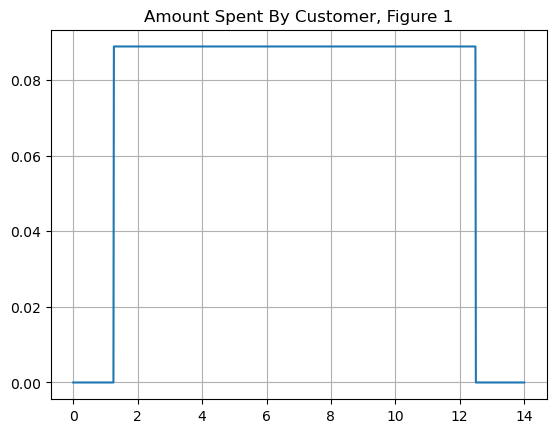

In [5]:
#Plot of amount spent by a customer on one visit to Blue Chip
x = np.linspace(0,14,1000)
uniform = lambda x,A,B: 1/(B-A)*(np.heaviside(x-A,1) - np.heaviside(x-B,1))
A = 1.25
B = 12.5
y = uniform(x,A,B)
plt.plot(x,y)
plt.title('Amount Spent By Customer, Figure 1')
plt.grid(True)
plt.show()

A represents the lowest amount spent by a costumer and B represents the highest amount spent by a costumer. Prices were taken from the Blue Chip menu$^2$.

In [6]:
#We use the average temperature over March as a reference, T0 so we fit a normal distrbution on it and calculate the mean
T_0 = weather[weather['month'] == 3]['avg_temperature'].mean()
print("T_0:" + str(T_0))

T_0:6.734714640198511


In [7]:
#We use the total daily precipitation over March as a reference, P0 so we fit a exponential distrbution on it and calculate the mean
#We shift the curve by 2mm to fit an exponential 
weather_1 = weather[weather['month'] == 3]['precipitation']
weather_2 = weather_1
weather_3 = weather_2 - 2
P_0 = weather_3.mean() + 2
print("P_0:" + str(P_0))

P_0:3.8638957816377175


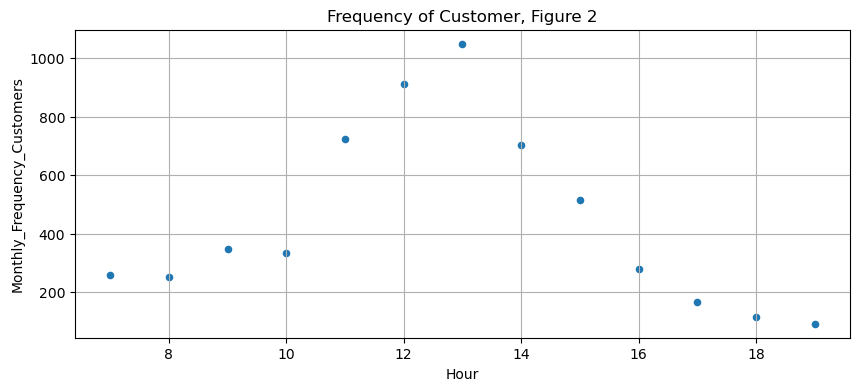

Total Customers in March: 5742
C_0: 191


In [8]:
#We plot the monthly frequency customers vs hour of the day and sum the values to find the reference number of customers, C0
customers.plot('Hour','Monthly_Frequency_Customers',kind='scatter',figsize=(10,4))
plt.grid(True)
plt.title('Frequency of Customer, Figure 2')
plt.show()
print("Total Customers in March: " + str(customers['Monthly_Frequency_Customers'].sum()))
print("C_0: " + str(round(customers['Monthly_Frequency_Customers'].sum()/30)))

In [9]:
n = 1000
N = 29 #average number of days the cafe is open in a month
C_0 = 191
a = 5.2
b = 2.6
A = 1.25
B = 12.5
Rs = []

#We run n simulations and calculate the revenue for each
for k in range(n):
    T_mean = []
    T_sd = []
    #We find the mean and variance of the average daily temperature for each month
    for i in range(1,13):
        mu = weather[weather['month'] == i]['avg_temperature'].mean()
        sigma = np.sqrt(weather[weather['month'] == i]['avg_temperature'].var())
        T_mean.append(mu)
        T_sd.append(sigma)
    
    P_mean = []
    #We find the mean and variance of the total daily precipitation for each month
    for i in range(1,13):
        weather_1 = weather[weather['month'] == i]['precipitation']
        weather_2 = weather_1[weather_1 > 2]
        weather_3 = weather_2 - 2
        mu = weather_3.mean() + 2
        P_mean.append(mu)
    
    T = []
    P = []
    #We take N random samples from the T and P distribution to calculate C for each month
    for i in range(0,12):
        T_i = stats.norm.rvs(loc=T_mean[i],scale=T_sd[i], size=N)
        T.append(T_i)
        P_i = stats.expon.rvs(loc=0, scale=P_mean[i], size=N)
        P.append(P_i)
    
    
    C = []
    #We calculate C for every single day Blue Chip is open over a year
    for i in range(12):
        for j in range(N):
            C_d = round(C_0 + a*(T[i][j] - T_0) - b*(P[i][j] - P_0))
            C.append(max(0,C_d))
    
    price = []
    #We randomly sample the amount each customer spends
    for i in range(len(C)):
        price_i = np.random.uniform(low=A,high=B,size=C[i])
        price.append(price_i)
    
    R = 0
    #We calculate the annual revenue of Blue Chip
    for day in price:
        for customer in day:
            R += customer
    
    Rs.append(R)

**Analyze and Assess**

One of the assumptions of our model is that the amount each customer spends at Blue Chip is uniformly distributed between the cost of the cheapest item and the most expensive item on the menu. However, this is likely on the lower end of spending, so we want to see how changing the values would affect total revenue. When we changed the high and low values from $ \$1.25$ and $ \$12.50$ to $ \$7.50$ and $ \$15$ (keeping the normal distribution), the mean yearly revenue went from $ \$481049$ to $ \$787388 $, which is a massive revenue shift and could represent a flaw in our assumptions - it would be useful to conduct a study on how much the average customer spends at blue chip in order to fine tune our model.

Another assumption that we chose to investigate was our values of $a$ and $b$, the rates of change of customers with respect to temperature and precipitation. We wanted to see how much these values would affect the final mean yearly revenue, and found that in this case it went from $ \$481500$ with our $a$ and $b$ values found in the article to $ \$435000$ when we switched the values (set $a = 2.6$ and $b = 5.2$), which makes sense as increasing $b$ while decreasing $a$ is bound to have a negative effect on revenue. Next we doubled the original values of $a$ and $b$, which found that revenue increased to $ \$515000$, which is a medium sized shift, implying that while $a$ and $b$ (the temperature and precipitation impacts on revenue) do have large effects on the revenue, the pricing and amount spent per customer is more impactful.

Another piece of our analysis was how likely it is that Blue Chip earns a revenue above the mean, $\$481049$, in a given year. We calculated this from the kde and found that there was a $52.94\%$ probability, given the values of A and B are $ \$1.25$ and $ \$12.50$ respectively. If you used values $ \$7.50$ and $ \$15$ for A and B, respectively, we would find that the propbability of earning reveune above the mean, $ \$787388 $, is $49.47\%$ 

**Report Results**

Mean of Revenue: 468535.11
Probability of revenue above the mean in a given year: 0.08 %


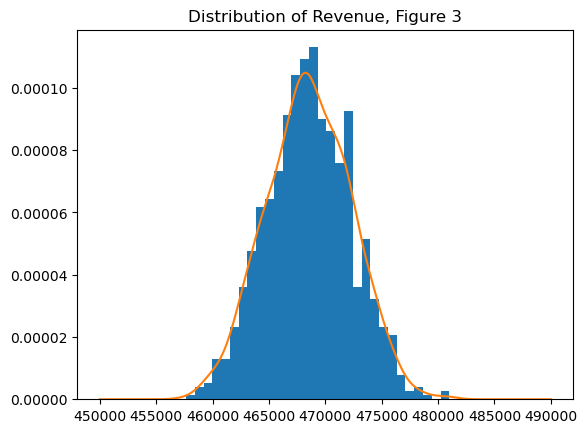

In [10]:
#We plot a histogram of the annual revenue earned by Blue Chip and fit a pdf over it using a Kernel Density Estimate
plt.hist(Rs, bins = 30, density = True)
kde = stats.gaussian_kde(Rs)
x = np.linspace(450000,490000,1000)
plt.plot(x,kde(x))
plt.title('Distribution of Revenue, Figure 3')
mean_Rs = np.mean(Rs)
print("Mean of Revenue:", round(mean_Rs,2))
print("Probability of revenue above the mean in a given year:", round(kde.integrate_box_1d(481049,np.inf),4)*100, "%")

**Citations**

[1] D., J. How weather affects restaurants sales. Liberty Interactive Marketing, LLC. https://teamupwithliberty.com/how-weather-affects-restaurants-sales/, (May 2023).

[2] AMS Student Society of UBC Vancouver. 2024 Blue Chip Menu Summer. Retrieved from https://www.ams.ubc.ca/wp-content/uploads/2024/07/2024-BlueChip-Menu-Summer.pdf